# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%matplotlib inline

import helper
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import problem_unittests as tests
import tensorflow as tf
import warnings

from distutils.version import LooseVersion
from glob import glob
from matplotlib import pyplot

print('All imports successful, ready to rip!')

All imports successful, ready to rip!


In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

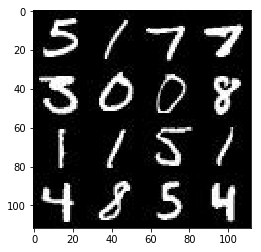

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

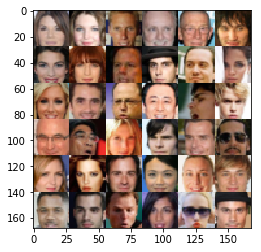

In [4]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),  name = 'input_real')
    z = tf.placeholder(tf.float32, (None, z_dim),  name = 'input_z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate_t')
    return image, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
D_NAME = 'discriminator'

def discriminator(images, reuse = False, alpha = .2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope(D_NAME, reuse = reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        # Training is always true because we are only interested in using the generator.
        # If need be, can set to false if we need to use this for inference
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flattened = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flattened, 1)
        activation_output = tf.sigmoid(logits)
        return activation_output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
G_NAME = 'generator'

def generator(z, out_channel_dim, is_train = True, alpha = .2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope(G_NAME, reuse = not is_train):
        x1 = tf.layers.dense(z, 2 * 2 * 512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training = is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides = 2, padding = 'valid')
        bn2 = tf.layers.batch_normalization(x2, training = is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides = 2, padding = 'same')
        # 28x28xout_channel_dim
        output_activation = tf.tanh(logits)
        return output_activation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha = .2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train = True)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha = alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, alpha = alpha)
    
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                          labels = tf.ones_like(d_model_real))
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                          labels = tf.zeros_like(d_model_fake))
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                     labels = tf.ones_like(d_model_fake))

    g_loss = tf.reduce_mean(g_loss)
    d_loss_real = tf.reduce_mean(d_loss_real)
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
  
    t_vars = tf.trainable_variables()
    d_vars = [tf_var for tf_var in t_vars if tf_var.name.startswith(D_NAME)]
    g_vars = [tf_var for tf_var in t_vars if tf_var.name.startswith(G_NAME)]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
        d_train_op = optimizer.minimize(d_loss, var_list = d_vars)
        g_train_op = optimizer.minimize(g_loss, var_list = g_vars)

        return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def show_generator_output(sess, input_z, out_channel_dim, image_mode, example_z):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    :param example_z: A fixed, but random, set of inputs (rather than generating from scratch each time)
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    #z_dim = input_z.get_shape().as_list()[-1]
    #example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.figure(figsize=(8, 8))
    pyplot.imshow(images_grid, cmap=cmap, aspect='equal')
    pyplot.show()
    
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def model_inputs_from_shape(data_shape, z_dim):
                   # image_width, image_height, image_channels, z_dim
    return model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

def train(epoch_count, batch_size, z_dim, learning_rate, beta1,
          get_batches, data_shape, data_image_mode,
          print_every = 10, show_every = 100,
          num_images_to_sample = 18,
          train_discriminator_every_N_steps = 2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    out_channel_dim = data_shape[3]
    input_real, input_z, lr_tensor = model_inputs_from_shape(data_shape, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_op, g_train_op = model_opt(d_loss, g_loss, lr_tensor, beta1)

    saver = tf.train.Saver()
    
    # We would prefer to use the same 'randomized' input so we can compare output over training time...
    sample_z = np.random.uniform(-1, 1, size=(num_images_to_sample, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2 # per https://discussions.udacity.com/t/need-help-with-final-project-discrimnator-loss-much-lower-than-the-generator-one/400443
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                if steps % train_discriminator_every_N_steps == 0: # original GAN paper mentioned certain number of times to train g vs d.
                    sess.run(d_train_op, feed_dict = {input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                sess.run(g_train_op, feed_dict = {input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Step {}, Epoch {}/{}'.format(steps, epoch_i + 1, epoch_count),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Geneator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = show_generator_output(sess, input_z,
                                          out_channel_dim, data_image_mode, sample_z)
                    samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        
    
    return losses, samples      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10, Epoch 1/2 Discriminator Loss: 0.4730... Geneator Loss: 5.4616
Step 20, Epoch 1/2 Discriminator Loss: 0.6819... Geneator Loss: 0.8917
Step 30, Epoch 1/2 Discriminator Loss: 0.4315... Geneator Loss: 7.5226
Step 40, Epoch 1/2 Discriminator Loss: 0.2452... Geneator Loss: 3.4064
Step 50, Epoch 1/2 Discriminator Loss: 1.3544... Geneator Loss: 9.4309
Step 60, Epoch 1/2 Discriminator Loss: 0.8574... Geneator Loss: 10.8055
Step 70, Epoch 1/2 Discriminator Loss: 1.4494... Geneator Loss: 6.8256
Step 80, Epoch 1/2 Discriminator Loss: 1.1195... Geneator Loss: 8.0453
Step 90, Epoch 1/2 Discriminator Loss: 0.9799... Geneator Loss: 1.8728
Step 100, Epoch 1/2 Discriminator Loss: 1.4346... Geneator Loss: 3.7146


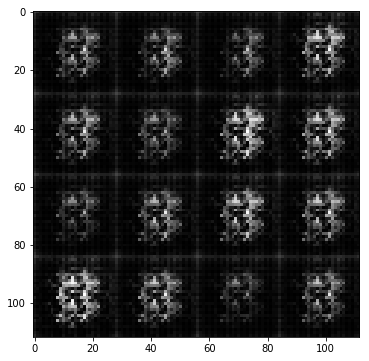

Step 110, Epoch 1/2 Discriminator Loss: 0.2313... Geneator Loss: 3.2953
Step 120, Epoch 1/2 Discriminator Loss: 1.4897... Geneator Loss: 2.2394
Step 130, Epoch 1/2 Discriminator Loss: 0.5500... Geneator Loss: 2.5408
Step 140, Epoch 1/2 Discriminator Loss: 0.4989... Geneator Loss: 3.6860
Step 150, Epoch 1/2 Discriminator Loss: 1.0264... Geneator Loss: 2.8035
Step 160, Epoch 1/2 Discriminator Loss: 0.3194... Geneator Loss: 3.0596
Step 170, Epoch 1/2 Discriminator Loss: 0.2934... Geneator Loss: 3.1598
Step 180, Epoch 1/2 Discriminator Loss: 0.1603... Geneator Loss: 3.6025
Step 190, Epoch 1/2 Discriminator Loss: 0.2122... Geneator Loss: 3.0984
Step 200, Epoch 1/2 Discriminator Loss: 0.8738... Geneator Loss: 2.4702


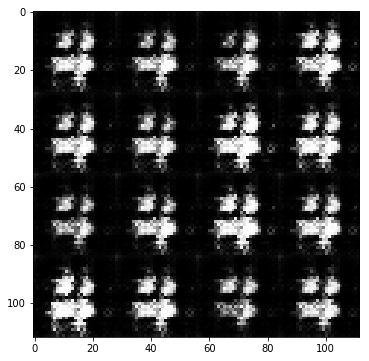

Step 210, Epoch 1/2 Discriminator Loss: 0.5671... Geneator Loss: 2.1763
Step 220, Epoch 1/2 Discriminator Loss: 1.1186... Geneator Loss: 7.2310
Step 230, Epoch 1/2 Discriminator Loss: 0.3787... Geneator Loss: 3.2972
Step 240, Epoch 1/2 Discriminator Loss: 0.3511... Geneator Loss: 3.5638
Step 250, Epoch 1/2 Discriminator Loss: 1.0501... Geneator Loss: 1.0216
Step 260, Epoch 1/2 Discriminator Loss: 0.2777... Geneator Loss: 3.4198
Step 270, Epoch 1/2 Discriminator Loss: 0.3142... Geneator Loss: 3.9806
Step 280, Epoch 1/2 Discriminator Loss: 0.3720... Geneator Loss: 3.0514
Step 290, Epoch 1/2 Discriminator Loss: 0.9702... Geneator Loss: 1.6183
Step 300, Epoch 1/2 Discriminator Loss: 1.0901... Geneator Loss: 3.6150


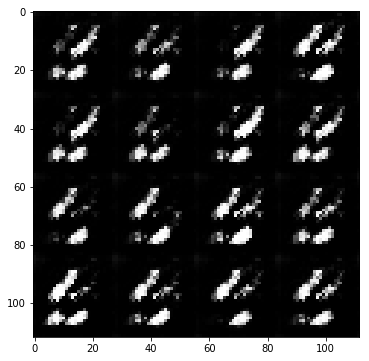

Step 310, Epoch 1/2 Discriminator Loss: 0.7263... Geneator Loss: 2.9984
Step 320, Epoch 1/2 Discriminator Loss: 0.5545... Geneator Loss: 2.1395
Step 330, Epoch 1/2 Discriminator Loss: 0.4296... Geneator Loss: 2.3683
Step 340, Epoch 1/2 Discriminator Loss: 0.5665... Geneator Loss: 2.1345
Step 350, Epoch 1/2 Discriminator Loss: 0.4897... Geneator Loss: 1.9960
Step 360, Epoch 1/2 Discriminator Loss: 0.5647... Geneator Loss: 1.8110
Step 370, Epoch 1/2 Discriminator Loss: 0.3795... Geneator Loss: 2.6019
Step 380, Epoch 1/2 Discriminator Loss: 0.3960... Geneator Loss: 2.0406
Step 390, Epoch 1/2 Discriminator Loss: 0.4564... Geneator Loss: 2.3666
Step 400, Epoch 1/2 Discriminator Loss: 0.4811... Geneator Loss: 2.9691


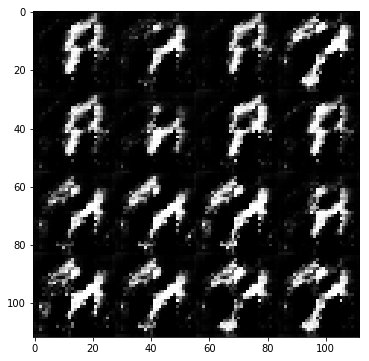

Step 410, Epoch 1/2 Discriminator Loss: 0.5313... Geneator Loss: 3.9791
Step 420, Epoch 1/2 Discriminator Loss: 0.2577... Geneator Loss: 3.3514
Step 430, Epoch 1/2 Discriminator Loss: 0.2269... Geneator Loss: 3.3724
Step 440, Epoch 1/2 Discriminator Loss: 0.4607... Geneator Loss: 1.9178
Step 450, Epoch 1/2 Discriminator Loss: 0.3548... Geneator Loss: 2.5313
Step 460, Epoch 1/2 Discriminator Loss: 0.3350... Geneator Loss: 2.7619
Step 470, Epoch 1/2 Discriminator Loss: 0.7734... Geneator Loss: 2.7217
Step 480, Epoch 1/2 Discriminator Loss: 0.3682... Geneator Loss: 3.1873
Step 490, Epoch 1/2 Discriminator Loss: 0.6683... Geneator Loss: 3.2106
Step 500, Epoch 1/2 Discriminator Loss: 0.4528... Geneator Loss: 3.6326


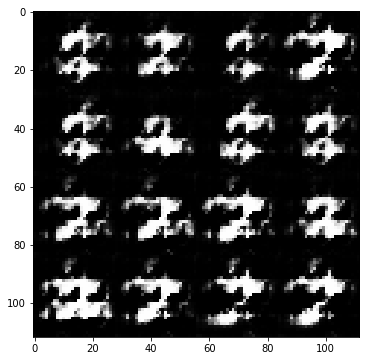

Step 510, Epoch 1/2 Discriminator Loss: 0.4589... Geneator Loss: 2.2185
Step 520, Epoch 1/2 Discriminator Loss: 0.3768... Geneator Loss: 3.7169
Step 530, Epoch 1/2 Discriminator Loss: 0.3334... Geneator Loss: 2.6589
Step 540, Epoch 1/2 Discriminator Loss: 0.3949... Geneator Loss: 2.4293
Step 550, Epoch 1/2 Discriminator Loss: 0.4429... Geneator Loss: 2.3094
Step 560, Epoch 1/2 Discriminator Loss: 0.5787... Geneator Loss: 1.7510
Step 570, Epoch 1/2 Discriminator Loss: 0.6719... Geneator Loss: 2.7349
Step 580, Epoch 1/2 Discriminator Loss: 0.7709... Geneator Loss: 3.0736
Step 590, Epoch 1/2 Discriminator Loss: 0.8545... Geneator Loss: 1.9234
Step 600, Epoch 1/2 Discriminator Loss: 0.5660... Geneator Loss: 2.0703


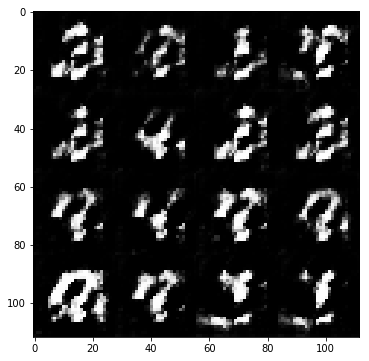

Step 610, Epoch 1/2 Discriminator Loss: 0.3503... Geneator Loss: 2.4268
Step 620, Epoch 1/2 Discriminator Loss: 0.5549... Geneator Loss: 2.2069
Step 630, Epoch 1/2 Discriminator Loss: 0.6292... Geneator Loss: 1.8167
Step 640, Epoch 1/2 Discriminator Loss: 0.6107... Geneator Loss: 2.7824
Step 650, Epoch 1/2 Discriminator Loss: 0.6062... Geneator Loss: 1.7419
Step 660, Epoch 1/2 Discriminator Loss: 0.7959... Geneator Loss: 1.2079
Step 670, Epoch 1/2 Discriminator Loss: 0.7804... Geneator Loss: 2.2245
Step 680, Epoch 1/2 Discriminator Loss: 0.8323... Geneator Loss: 3.9022
Step 690, Epoch 1/2 Discriminator Loss: 0.9371... Geneator Loss: 0.8590
Step 700, Epoch 1/2 Discriminator Loss: 0.6435... Geneator Loss: 1.6360


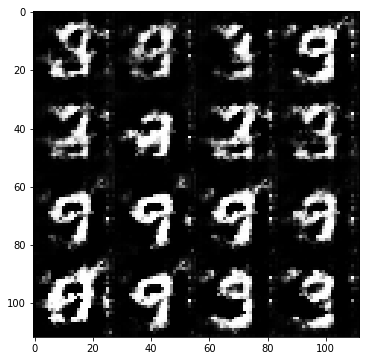

Step 710, Epoch 1/2 Discriminator Loss: 0.6320... Geneator Loss: 1.7863
Step 720, Epoch 1/2 Discriminator Loss: 0.6754... Geneator Loss: 1.5030
Step 730, Epoch 1/2 Discriminator Loss: 0.5248... Geneator Loss: 1.9971
Step 740, Epoch 1/2 Discriminator Loss: 0.9816... Geneator Loss: 0.8810
Step 750, Epoch 1/2 Discriminator Loss: 0.5796... Geneator Loss: 2.7064
Step 760, Epoch 1/2 Discriminator Loss: 0.5214... Geneator Loss: 2.1151
Step 770, Epoch 1/2 Discriminator Loss: 0.5104... Geneator Loss: 1.6338
Step 780, Epoch 1/2 Discriminator Loss: 0.5694... Geneator Loss: 1.4976
Step 790, Epoch 1/2 Discriminator Loss: 0.5081... Geneator Loss: 2.3365
Step 800, Epoch 1/2 Discriminator Loss: 0.6814... Geneator Loss: 2.2329


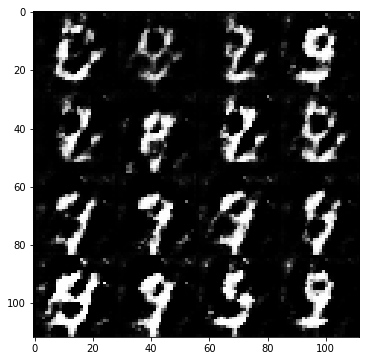

Step 810, Epoch 1/2 Discriminator Loss: 1.0547... Geneator Loss: 3.0155
Step 820, Epoch 1/2 Discriminator Loss: 0.6630... Geneator Loss: 2.5825
Step 830, Epoch 1/2 Discriminator Loss: 0.4836... Geneator Loss: 2.0108
Step 840, Epoch 1/2 Discriminator Loss: 0.5228... Geneator Loss: 1.8772
Step 850, Epoch 1/2 Discriminator Loss: 0.9323... Geneator Loss: 1.4925
Step 860, Epoch 1/2 Discriminator Loss: 0.5531... Geneator Loss: 2.2288
Step 870, Epoch 1/2 Discriminator Loss: 0.7319... Geneator Loss: 1.7566
Step 880, Epoch 1/2 Discriminator Loss: 0.9511... Geneator Loss: 0.9016
Step 890, Epoch 1/2 Discriminator Loss: 0.5610... Geneator Loss: 1.3922
Step 900, Epoch 1/2 Discriminator Loss: 0.5299... Geneator Loss: 2.3828


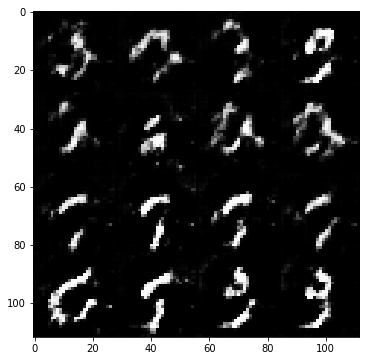

Step 910, Epoch 1/2 Discriminator Loss: 1.0427... Geneator Loss: 1.0822
Step 920, Epoch 1/2 Discriminator Loss: 0.6156... Geneator Loss: 2.4339
Step 930, Epoch 1/2 Discriminator Loss: 0.8570... Geneator Loss: 2.2769
Step 940, Epoch 2/2 Discriminator Loss: 0.7439... Geneator Loss: 1.1816
Step 950, Epoch 2/2 Discriminator Loss: 0.9643... Geneator Loss: 1.3007
Step 960, Epoch 2/2 Discriminator Loss: 0.7345... Geneator Loss: 1.0665
Step 970, Epoch 2/2 Discriminator Loss: 0.7970... Geneator Loss: 1.6029
Step 980, Epoch 2/2 Discriminator Loss: 0.7947... Geneator Loss: 1.5198
Step 990, Epoch 2/2 Discriminator Loss: 0.8063... Geneator Loss: 2.1882
Step 1000, Epoch 2/2 Discriminator Loss: 0.6948... Geneator Loss: 1.4424


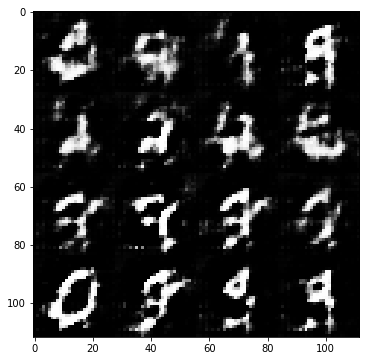

Step 1010, Epoch 2/2 Discriminator Loss: 0.7682... Geneator Loss: 1.3738
Step 1020, Epoch 2/2 Discriminator Loss: 0.7531... Geneator Loss: 1.9630
Step 1030, Epoch 2/2 Discriminator Loss: 0.8970... Geneator Loss: 1.4285
Step 1040, Epoch 2/2 Discriminator Loss: 1.1480... Geneator Loss: 0.5286
Step 1050, Epoch 2/2 Discriminator Loss: 0.9914... Geneator Loss: 1.4255
Step 1060, Epoch 2/2 Discriminator Loss: 0.6011... Geneator Loss: 1.4125
Step 1070, Epoch 2/2 Discriminator Loss: 1.1734... Geneator Loss: 1.9366
Step 1080, Epoch 2/2 Discriminator Loss: 0.6963... Geneator Loss: 1.4163
Step 1090, Epoch 2/2 Discriminator Loss: 0.7963... Geneator Loss: 1.2693
Step 1100, Epoch 2/2 Discriminator Loss: 0.8524... Geneator Loss: 1.7965


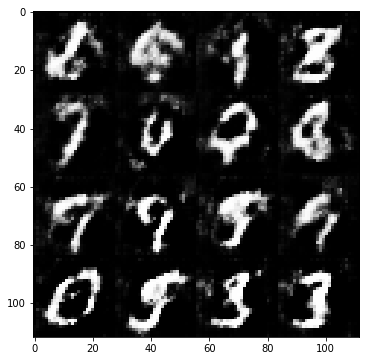

Step 1110, Epoch 2/2 Discriminator Loss: 1.2316... Geneator Loss: 1.7932
Step 1120, Epoch 2/2 Discriminator Loss: 0.8141... Geneator Loss: 1.5532
Step 1130, Epoch 2/2 Discriminator Loss: 0.8152... Geneator Loss: 1.3819
Step 1140, Epoch 2/2 Discriminator Loss: 0.9619... Geneator Loss: 0.9196
Step 1150, Epoch 2/2 Discriminator Loss: 0.8210... Geneator Loss: 1.2499
Step 1160, Epoch 2/2 Discriminator Loss: 0.8114... Geneator Loss: 1.2119
Step 1170, Epoch 2/2 Discriminator Loss: 1.4572... Geneator Loss: 2.5871
Step 1180, Epoch 2/2 Discriminator Loss: 0.7791... Geneator Loss: 1.6858
Step 1190, Epoch 2/2 Discriminator Loss: 0.8766... Geneator Loss: 1.1909
Step 1200, Epoch 2/2 Discriminator Loss: 1.2471... Geneator Loss: 0.4850


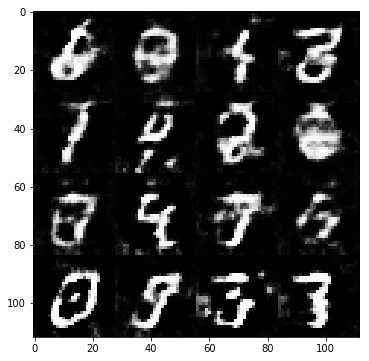

Step 1210, Epoch 2/2 Discriminator Loss: 0.7699... Geneator Loss: 1.1664
Step 1220, Epoch 2/2 Discriminator Loss: 0.8715... Geneator Loss: 1.0698
Step 1230, Epoch 2/2 Discriminator Loss: 0.8673... Geneator Loss: 1.2566
Step 1240, Epoch 2/2 Discriminator Loss: 0.9992... Geneator Loss: 1.9320
Step 1250, Epoch 2/2 Discriminator Loss: 0.9501... Geneator Loss: 1.7568
Step 1260, Epoch 2/2 Discriminator Loss: 1.0929... Geneator Loss: 1.0110
Step 1270, Epoch 2/2 Discriminator Loss: 0.9915... Geneator Loss: 1.9440
Step 1280, Epoch 2/2 Discriminator Loss: 0.9535... Geneator Loss: 1.2006
Step 1290, Epoch 2/2 Discriminator Loss: 0.8862... Geneator Loss: 0.9800
Step 1300, Epoch 2/2 Discriminator Loss: 1.1907... Geneator Loss: 2.2882


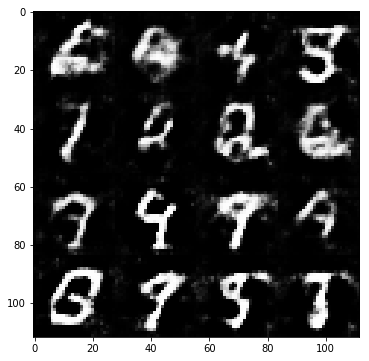

Step 1310, Epoch 2/2 Discriminator Loss: 0.8092... Geneator Loss: 1.1162
Step 1320, Epoch 2/2 Discriminator Loss: 0.8388... Geneator Loss: 1.4755
Step 1330, Epoch 2/2 Discriminator Loss: 1.0982... Geneator Loss: 0.8040
Step 1340, Epoch 2/2 Discriminator Loss: 0.9857... Geneator Loss: 1.4340
Step 1350, Epoch 2/2 Discriminator Loss: 0.8119... Geneator Loss: 1.0759
Step 1360, Epoch 2/2 Discriminator Loss: 1.1041... Geneator Loss: 0.6239
Step 1370, Epoch 2/2 Discriminator Loss: 0.8424... Geneator Loss: 1.4952
Step 1380, Epoch 2/2 Discriminator Loss: 0.9432... Geneator Loss: 0.9361
Step 1390, Epoch 2/2 Discriminator Loss: 0.7520... Geneator Loss: 1.2036
Step 1400, Epoch 2/2 Discriminator Loss: 1.8195... Geneator Loss: 3.0949


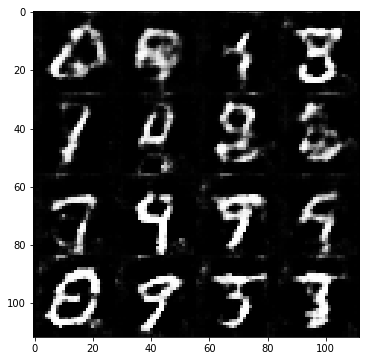

Step 1410, Epoch 2/2 Discriminator Loss: 0.8701... Geneator Loss: 1.1054
Step 1420, Epoch 2/2 Discriminator Loss: 0.9063... Geneator Loss: 0.9971
Step 1430, Epoch 2/2 Discriminator Loss: 0.8966... Geneator Loss: 1.1440
Step 1440, Epoch 2/2 Discriminator Loss: 1.4160... Geneator Loss: 2.5432
Step 1450, Epoch 2/2 Discriminator Loss: 0.9720... Geneator Loss: 1.1814
Step 1460, Epoch 2/2 Discriminator Loss: 0.8734... Geneator Loss: 1.0653
Step 1470, Epoch 2/2 Discriminator Loss: 0.9520... Geneator Loss: 0.8897
Step 1480, Epoch 2/2 Discriminator Loss: 1.3573... Geneator Loss: 0.4072
Step 1490, Epoch 2/2 Discriminator Loss: 0.9607... Geneator Loss: 0.8932
Step 1500, Epoch 2/2 Discriminator Loss: 1.3201... Geneator Loss: 0.4194


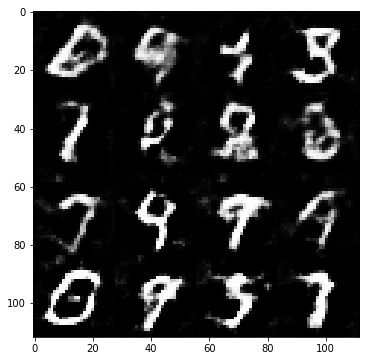

Step 1510, Epoch 2/2 Discriminator Loss: 1.1359... Geneator Loss: 1.6436
Step 1520, Epoch 2/2 Discriminator Loss: 1.0737... Geneator Loss: 0.7118
Step 1530, Epoch 2/2 Discriminator Loss: 0.8773... Geneator Loss: 1.1468
Step 1540, Epoch 2/2 Discriminator Loss: 0.8917... Geneator Loss: 1.0246
Step 1550, Epoch 2/2 Discriminator Loss: 1.1689... Geneator Loss: 1.8052
Step 1560, Epoch 2/2 Discriminator Loss: 0.9336... Geneator Loss: 0.8574
Step 1570, Epoch 2/2 Discriminator Loss: 1.0691... Geneator Loss: 0.7472
Step 1580, Epoch 2/2 Discriminator Loss: 0.8457... Geneator Loss: 1.2441
Step 1590, Epoch 2/2 Discriminator Loss: 1.1344... Geneator Loss: 0.5481
Step 1600, Epoch 2/2 Discriminator Loss: 1.0459... Geneator Loss: 1.2319


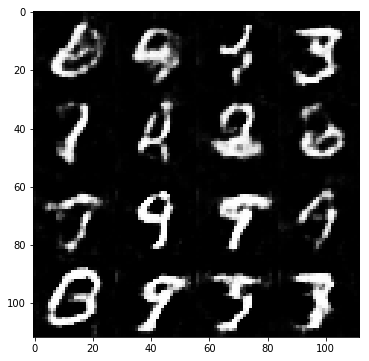

Step 1610, Epoch 2/2 Discriminator Loss: 1.1267... Geneator Loss: 0.6045
Step 1620, Epoch 2/2 Discriminator Loss: 0.8799... Geneator Loss: 1.3992
Step 1630, Epoch 2/2 Discriminator Loss: 0.9857... Geneator Loss: 1.1563
Step 1640, Epoch 2/2 Discriminator Loss: 0.9778... Geneator Loss: 0.6730
Step 1650, Epoch 2/2 Discriminator Loss: 1.0277... Geneator Loss: 1.1268
Step 1660, Epoch 2/2 Discriminator Loss: 1.0903... Geneator Loss: 1.2535
Step 1670, Epoch 2/2 Discriminator Loss: 1.1397... Geneator Loss: 0.7285
Step 1680, Epoch 2/2 Discriminator Loss: 1.0106... Geneator Loss: 1.3912
Step 1690, Epoch 2/2 Discriminator Loss: 1.3347... Geneator Loss: 0.4509
Step 1700, Epoch 2/2 Discriminator Loss: 0.8556... Geneator Loss: 1.3112


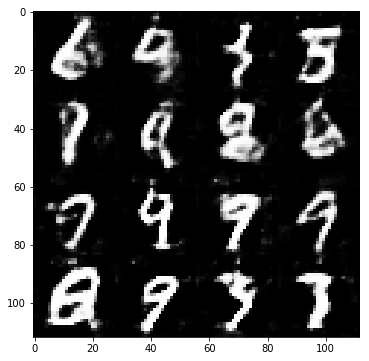

Step 1710, Epoch 2/2 Discriminator Loss: 1.0867... Geneator Loss: 0.6608
Step 1720, Epoch 2/2 Discriminator Loss: 1.1147... Geneator Loss: 1.1658
Step 1730, Epoch 2/2 Discriminator Loss: 1.4838... Geneator Loss: 2.1568
Step 1740, Epoch 2/2 Discriminator Loss: 1.1100... Geneator Loss: 1.4277
Step 1750, Epoch 2/2 Discriminator Loss: 0.9463... Geneator Loss: 1.5698
Step 1760, Epoch 2/2 Discriminator Loss: 1.1739... Geneator Loss: 0.5679
Step 1770, Epoch 2/2 Discriminator Loss: 1.1486... Geneator Loss: 0.8075
Step 1780, Epoch 2/2 Discriminator Loss: 1.3444... Geneator Loss: 1.6930
Step 1790, Epoch 2/2 Discriminator Loss: 1.2279... Geneator Loss: 0.4825
Step 1800, Epoch 2/2 Discriminator Loss: 0.9839... Geneator Loss: 0.7192


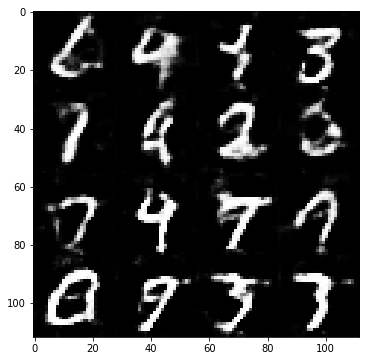

Step 1810, Epoch 2/2 Discriminator Loss: 1.0926... Geneator Loss: 0.9629
Step 1820, Epoch 2/2 Discriminator Loss: 1.1286... Geneator Loss: 1.3537
Step 1830, Epoch 2/2 Discriminator Loss: 1.0106... Geneator Loss: 0.7156
Step 1840, Epoch 2/2 Discriminator Loss: 1.0688... Geneator Loss: 0.6645
Step 1850, Epoch 2/2 Discriminator Loss: 1.1247... Geneator Loss: 0.6985
Step 1860, Epoch 2/2 Discriminator Loss: 1.0356... Geneator Loss: 0.7763
Step 1870, Epoch 2/2 Discriminator Loss: 1.0220... Geneator Loss: 1.3772
all done!


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

losses = []
samples = []
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1,
                            mnist_dataset.get_batches,
                            mnist_dataset.shape, mnist_dataset.image_mode)
    
print('all done!')

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

print('all done!')

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.